# Ridge & Lasso Regression

We will be using a small dataset to predict the target variable using basic linear regression, ridge regression and Lasso. First, we import the library functions we need.

In [1]:
# import all the required libraries and put matplotlib in inline mode to plot on the notebook
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We generate datapoints and plot them.

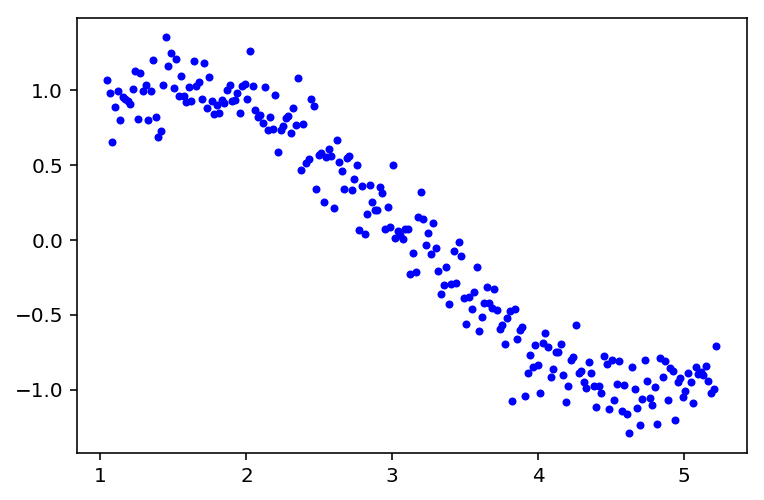

In [2]:
x = np.array([i*np.pi/180 for i in range(60,300,1)])
np.random.seed(10)  # Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
dataset = pd.DataFrame({'x':x, 'y':y})

plt.plot(dataset['x'],dataset['y'],'.', color='blue');

In [3]:
train, test = model_selection.train_test_split(dataset, test_size=0.33, random_state=1234)

We define the usual functions to compute the value of the polynomial given x, to generate the variables used for polynomial approximation and to plot the resulting approximation.

In [4]:
def compute_polynomial_model(x, coef, intercept):
    """Compute the polynomial given the input x, the intercept and the coefficients"""
    min_x = min(x)
    max_x = max(x)
    xp = np.arange(min_x, max_x, (max_x-min_x)/100.0)

    x = xp
    yp = intercept

    for w in coef:
        yp = yp + w * x
        x = x * xp
    return xp,yp

def generate_variables(original_column, degree):
    """Generates the list of variables for a polynomial approximator"""
    v = [original_column]
    for d in range(2,degree+1):
        v.append(original_column+str(d))
    return v

def add_degrees(dataset,original_column, degree):
    """Given a column name and the degree of a polynomial, it adds 
    all the extra columns needed for a polynomial approximator"""
    
    new_dataset = dataset
    current_column = original_column
    for d in range(2,degree+1):
        column_name = original_column+str(d)

        new_dataset[column_name] = new_dataset[current_column]*dataset[original_column]

        current_column = column_name

    return new_dataset

def plot_approximator(x,y,xp,yp,title=""):
    """Plots the original data (x,y) and a set of point (xp,yp) showing the model approximation"""
    font = {'family' : 'sans',
        'size'   : 14}
    plt.rc('font', **font)

    plt.scatter(x, y,  color='blue')
    plt.plot(xp, yp, color='red', linewidth=3)
    plt.xlabel("x")
    plt.ylabel("y")
    
    if (title!=""):
        plt.title(title)

    plt.show()

We also define the function to compute the polynomial regression for one input variable, one output variable and a degree

In [5]:
def compute_polynomial_regression(dataset, variable, target, degree):
    """Given the dataset the name of the input variable, the target and the degree of the polynomial,
    it computes linear regression using basic least squares"""
    
    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x
    y = dataset_train_y

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    yp = regr.predict(x)

    mse= metrics.mean_squared_error(y_pred=yp, y_true=y)
    r2 = regr.score(x,y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_,regr.intercept_)))
    
    return xm, ym, yp, mse, r2, regr

Same function with the evaluation using a test set. By default the train/test sets are split as 2/3 1/3

In [6]:
def compute_polynomial_regression_holdout(dataset, variable, target, degree, test_size=0.33, random_state=1234):
    '''Computes MSE and R2 statistics over the train and test set.

    test_size is the percentage of data used for testing (default is 1/3)
    random_state is the seed used for sampling the data and it is used for replicability

    '''
    
    ### Add higher degree of the target variable
    extended_dataset = add_degrees(dataset, variable, degree)

    ### Split train and test
    train_x, test_x, train_y, test_y = model_selection.train_test_split(dataset[generate_variables(variable,degree)],dataset[target], test_size=0.33, random_state=1234)

    
    regr = linear_model.LinearRegression()
    regr.fit(train_x, train_y)

    y_predicted_from_test = regr.predict(test_x)
    
    mse= metrics.mean_squared_error(y_pred=y_predicted_from_test, y_true=test_y)
    r2 = metrics.r2_score(y_pred=y_predicted_from_test, y_true=test_y)
    
    # the abscissa
    xm,ym = compute_polynomial_model(train_x.iloc[:,0],regr.coef_, regr.intercept_)

    return mse, r2, xm, ym, regr

Let's plot various approximations using different polynomials.

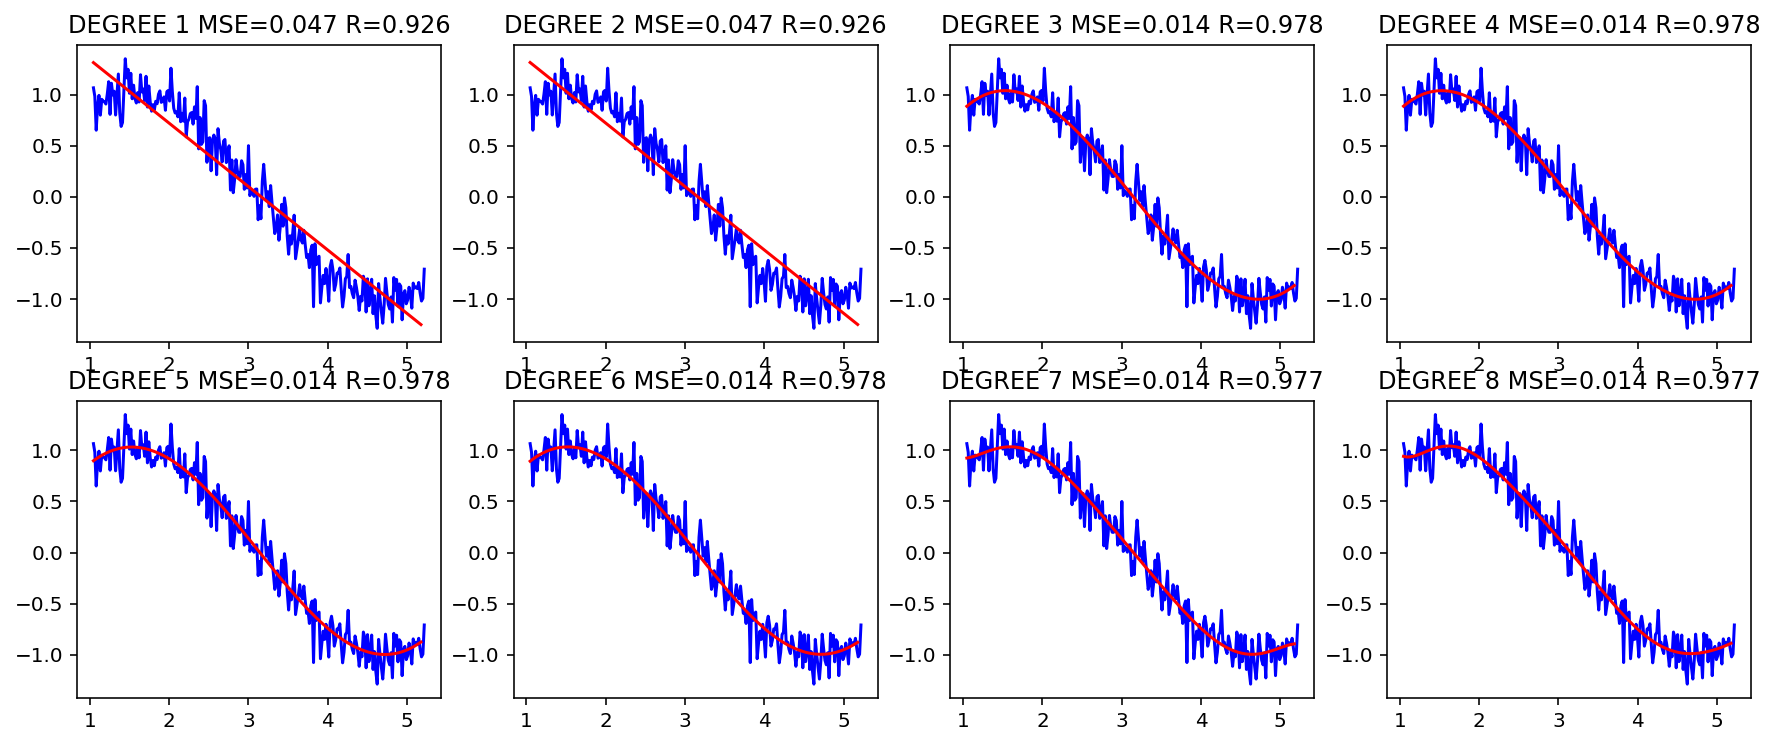

In [7]:
max_polynomial = 8

plt.rcParams['figure.figsize'] = (15, 6)
f, axarr = plt.subplots(2, 4)

for degree in range(0,max_polynomial):
    mse, r2, xm, ym, regr = compute_polynomial_regression_holdout(dataset,'x', 'y', degree+1)
    title = "DEGREE "+str(degree + 1)+" MSE=" + str(round(mse,3))+" R="+str(round(r2,3))
    axarr[int(degree/4),int(degree%4)].plot(dataset['x'],dataset['y'], color="blue")
    axarr[int(degree/4),int(degree%4)].set_title(title)
    axarr[int(degree/4),int(degree%4)].plot(xm,ym, color="red")

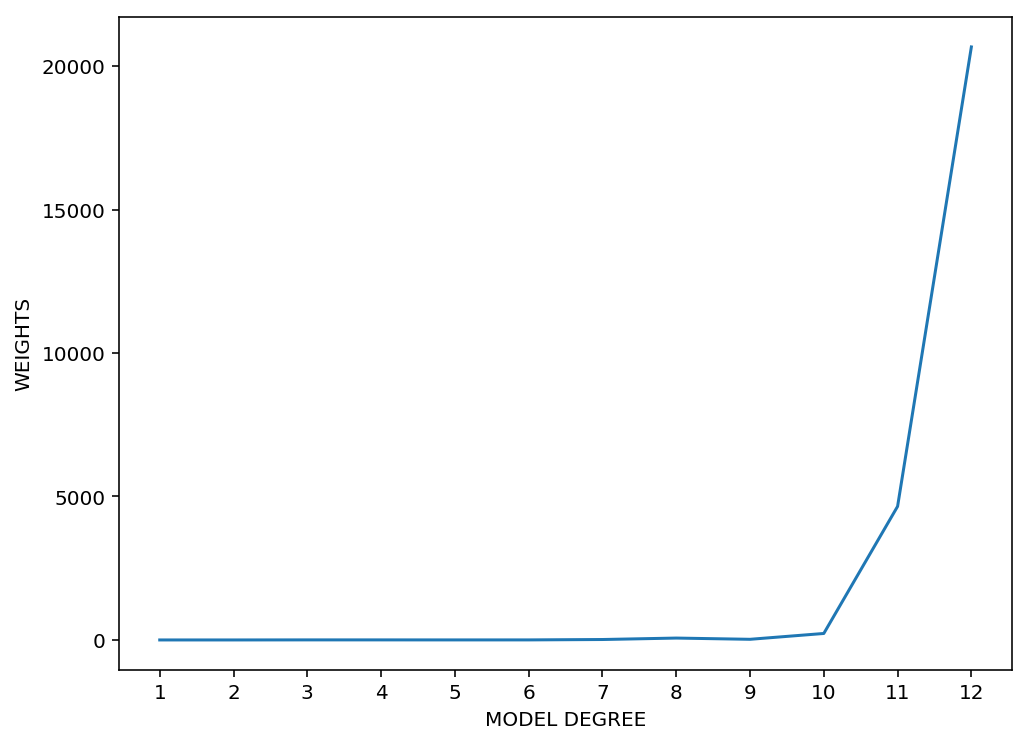

In [8]:
max_polynomial = 12
plt.rcParams['figure.figsize'] = (8, 6)
weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, mse, r2, regr = compute_polynomial_regression(dataset,'x', 'y', degree+1)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_)))
    
plt.xticks(range(1,max_polynomial+1))   
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xlabel("MODEL DEGREE")
plt.ylabel("WEIGHTS")

We now repeat the process using Ridge regression that define cost as, MSE($\vec{w}$) + $\alpha||\vec{w}||_2^2$

In [9]:
def compute_polynomial_ridge(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    x = extended_dataset[generate_variables(variable,degree)].values
    y = extended_dataset[target].values

    regr = linear_model.Ridge(alpha=a)
    regr.fit(x, y)

    yp = regr.predict(x)

    mse =metrics.mean_squared_error(y_pred=yp, y_true=y)
    r2 = metrics.r2_score(y_pred=yp, y_true=y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_)))

    return xm, ym, yp, mse, r2, regr

By penalizing larger weights, ridge regression computes smaller weight values.

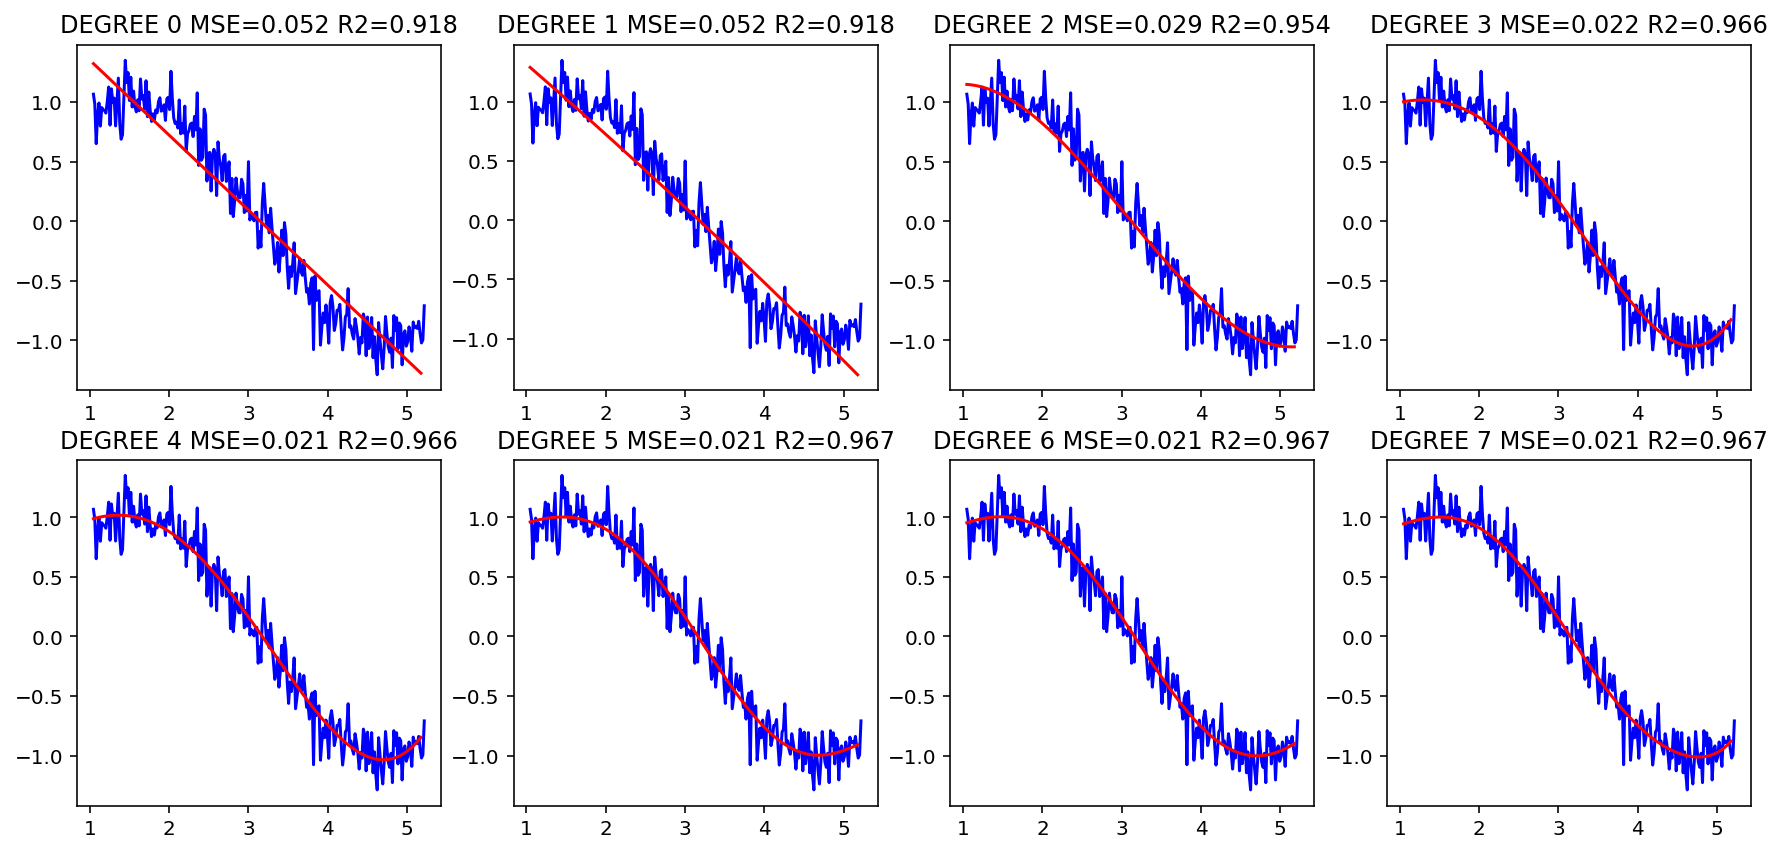

In [10]:
max_polynomial = 8
plt.rcParams['figure.figsize'] = (15, 7)
f, axarr = plt.subplots(2, 4)

for degree in range(0,max_polynomial):
    xm, ym, yp, mse, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', degree+1)
    title = "DEGREE "+str(degree)+" MSE=" + str(round(mse,3))+" R2="+str(round(r2,3))
    axarr[int(degree/4),int(degree%4)].plot(dataset['x'],dataset['y'], color="blue")
    axarr[int(degree/4),int(degree%4)].set_title(title)
    axarr[int(degree/4),int(degree%4)].plot(xm,ym, color="red")

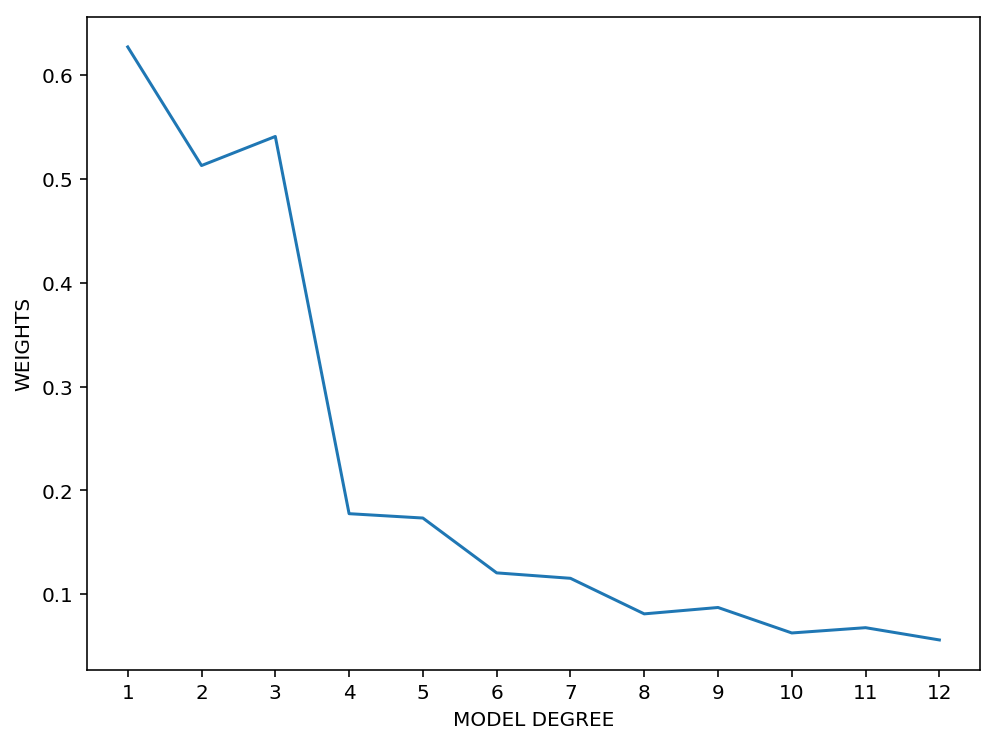

In [11]:
max_polynomial = 12
plt.rcParams['figure.figsize'] = (8, 6)
weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, mse, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', degree+1, a=2.0)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_)))
    
plt.xticks(range(1,max_polynomial+1))   
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xlabel("MODEL DEGREE")
plt.ylabel("WEIGHTS")

Let's see how the final weights vary based on the value of $\lambda$ (note that the functions of sklearn use $\alpha$ as a coefficient, but it is equivalent to the lambda in the slides.

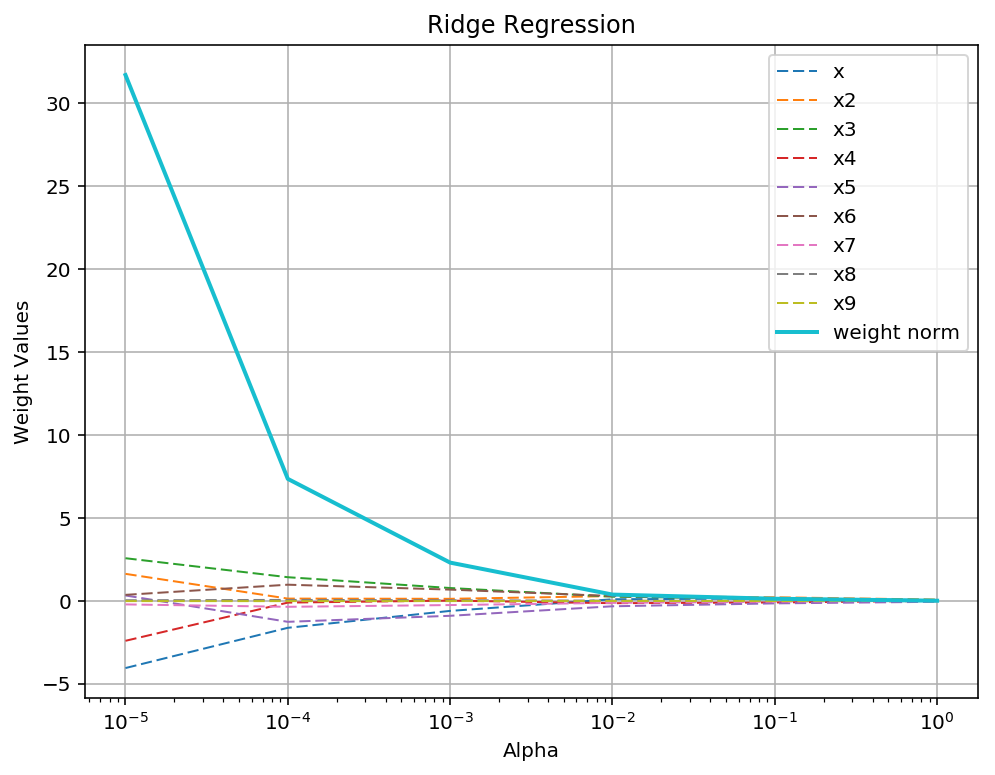

In [12]:
plt.rcParams['figure.figsize'] = (8, 6)
set_of_alphas = [1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]

weights = []

fig, ax = plt.subplots()
ax.set_xscale('log')

for alpha in set_of_alphas:
    xm, ym, yp, mse, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', 10, a=alpha)
    weights.append(regr.coef_)
                   
weight_matrix = pd.DataFrame(weights)

weight_matrix.columns = generate_variables('x',10)
plt.plot(set_of_alphas, weight_matrix['x'], '--', linewidth=1, label = 'x')
plt.plot(set_of_alphas, weight_matrix['x2'], '--', linewidth=1, label = 'x2')
plt.plot(set_of_alphas, weight_matrix['x3'], '--', linewidth=1, label = 'x3')
plt.plot(set_of_alphas, weight_matrix['x4'], '--', linewidth=1, label = 'x4')
plt.plot(set_of_alphas, weight_matrix['x5'], '--', linewidth=1, label = 'x5')
plt.plot(set_of_alphas, weight_matrix['x6'], '--', linewidth=1, label = 'x6')
plt.plot(set_of_alphas, weight_matrix['x7'], '--', linewidth=1, label = 'x7')
plt.plot(set_of_alphas, weight_matrix['x8'], '--', linewidth=1, label = 'x8')
plt.plot(set_of_alphas, weight_matrix['x9'], '--', linewidth=1, label = 'x9')
plt.plot(set_of_alphas, weight_matrix.apply(lambda x: np.sum(x**2), axis = 1), linewidth=2, label = 'weight norm')

plt.title('Ridge Regression')
plt.xlabel('Alpha')
plt.ylabel('Weight Values')

plt.legend(loc = 0)

plt.grid()

Let's repeat everything using Lasso regression.

In [13]:
def compute_polynomial_lasso(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    x = extended_dataset[generate_variables(variable,degree)].values
    y = extended_dataset[target].values

    regr = linear_model.Lasso(alpha=a)
    regr.fit(x, y)

    yp = regr.predict(x)

    mse = metrics.mean_squared_error(y_pred=yp, y_true=y)
    r2 = metrics.r2_score(y_pred=yp, y_true=y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_)))

    return xm, ym, yp, mse, r2, regr

In [14]:
def compute_polynomial_lasso_holdout(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    ### Split train and test
    train_x, test_x, train_y, test_y = model_selection.train_test_split(dataset[generate_variables(variable,degree)],
                                                                        dataset[target], test_size=0.33, random_state=1234)

    
    regr = linear_model.Lasso(alpha=a)
    regr.fit(train_x, train_y)

    y_predicted_from_test = regr.predict(test_x)
    
    mse= metrics.mean_squared_error(y_pred=y_predicted_from_test, y_true=test_y)
    r2 = metrics.r2_score(y_pred=y_predicted_from_test, y_true=test_y)
    
    # the abscissa
    xm,ym = compute_polynomial_model(train_x.iloc[:,0],regr.coef_, regr.intercept_)

    return mse, r2, xm, ym, regr

C:\Users\APonzio\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


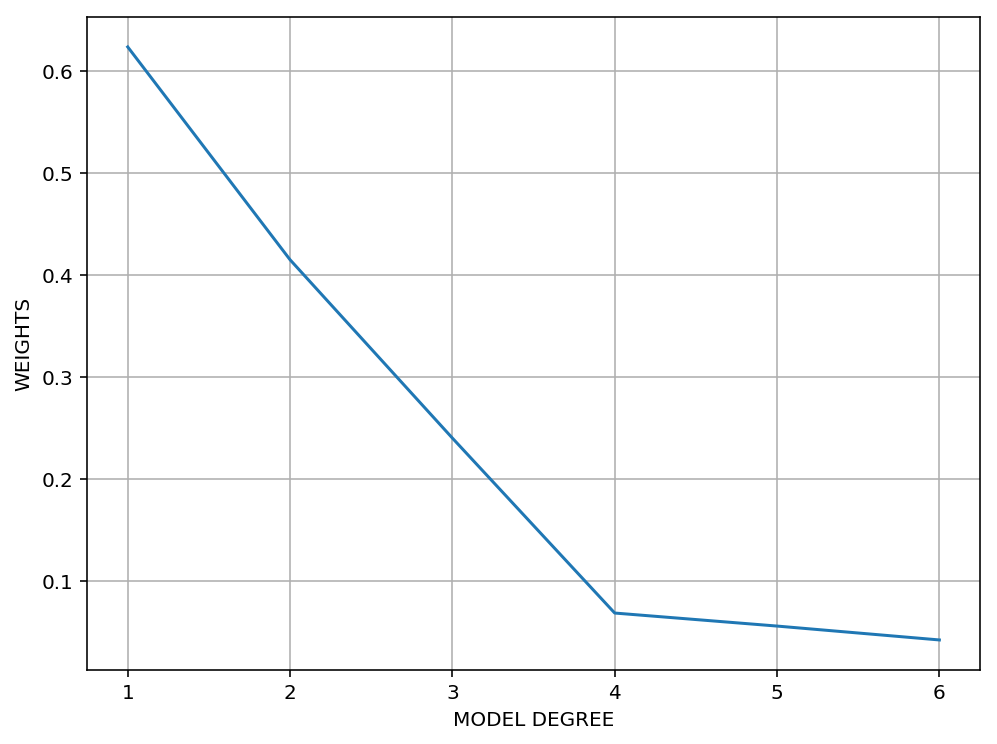

In [15]:
max_polynomial = 6
plt.rcParams['figure.figsize'] = (8, 6)
weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, mse, r2, regr = compute_polynomial_lasso(dataset,'x', 'y', degree+1, a=0.01)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_)))

plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.grid()
plt.xlabel("MODEL DEGREE")
plt.ylabel("WEIGHTS")

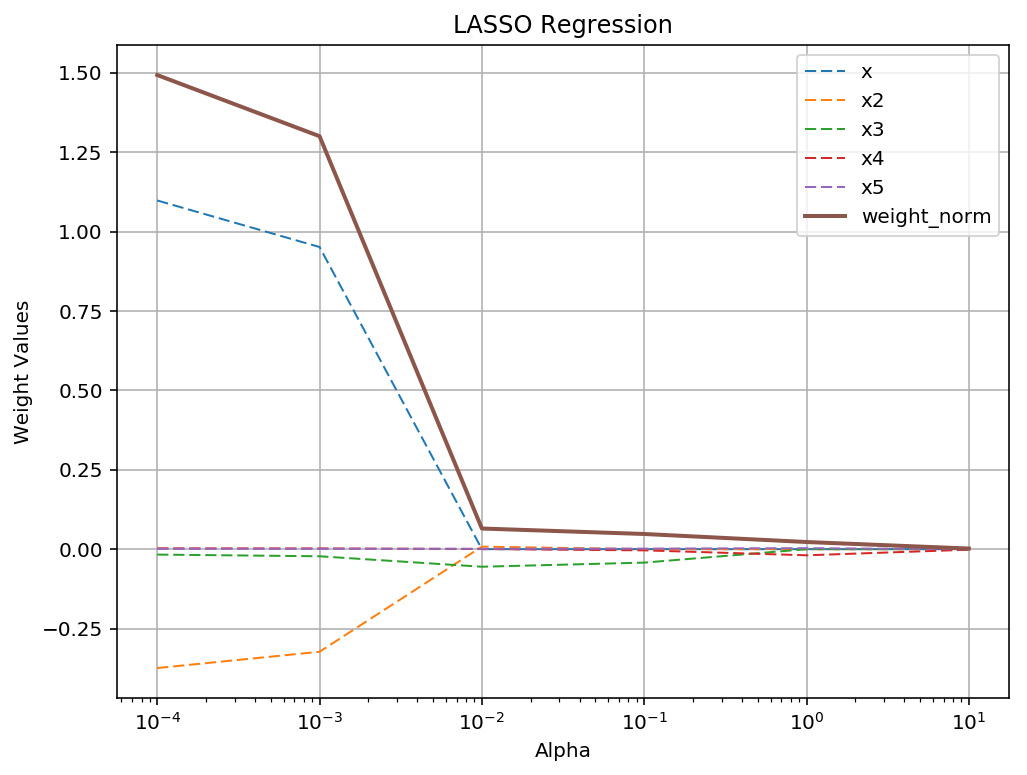

In [16]:
set_of_alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
weights = []

fig, ax = plt.subplots()
ax.set_xscale('log')

for alpha in set_of_alphas:
    xm, ym, yp, mse, r2, regr = compute_polynomial_lasso(dataset,'x', 'y', 5, a=alpha)
    weights.append(regr.coef_)
                   
weight_matrix = pd.DataFrame(weights)

weight_matrix.columns = generate_variables('x',5)
plt.plot(set_of_alphas, weight_matrix['x'], '--', linewidth=1, label = 'x')
plt.plot(set_of_alphas, weight_matrix['x2'], '--', linewidth=1, label = 'x2')
plt.plot(set_of_alphas, weight_matrix['x3'], '--', linewidth=1, label = 'x3')
plt.plot(set_of_alphas, weight_matrix['x4'], '--', linewidth=1, label = 'x4')
plt.plot(set_of_alphas, weight_matrix['x5'], '--', linewidth=1, label = 'x5')
plt.plot(set_of_alphas, weight_matrix.apply(lambda x: np.sum(abs(x)), axis = 1), linewidth=2, label = 'weight_norm')

plt.title('LASSO Regression')
plt.xlabel('Alpha')
plt.ylabel('Weight Values')

plt.legend(loc = 0)
plt.grid()

## $\alpha$ Selection

Let's score the models up to the 40th degree polynomial

(0.10501774351049172, 0.015085855477782184)

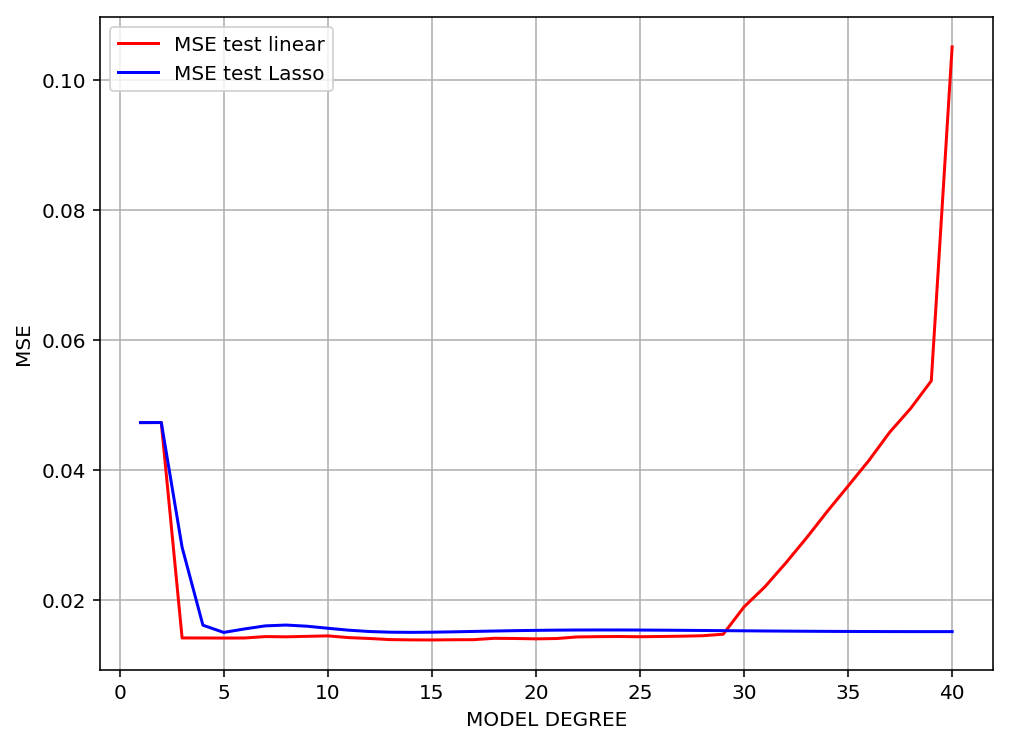

In [17]:
max_polynomial = 40
mse_lasso = np.zeros(max_polynomial)
mse = np.zeros(max_polynomial)
r2_lasso = np.zeros(max_polynomial)
r2 = np.zeros(max_polynomial)


plt.rcParams['figure.figsize'] = (8, 6)

for i in range(max_polynomial):
    mse_lasso[i],r2_lasso[i],_,_,_ = compute_polynomial_lasso_holdout(dataset,'x','y',i+1, a=1e-20)
    mse[i],r2[i],_,_,_  = compute_polynomial_regression_holdout(dataset,'x','y',i+1)

plt.xlabel("MODEL DEGREE")
plt.ylabel("MSE")
plt.grid()
    
plt.plot(range(1,max_polynomial+1), mse, c='red', label = 'MSE test linear')
plt.plot(range(1,max_polynomial+1), mse_lasso, c='blue', label = 'MSE test Lasso')

plt.legend(loc = 0)

mse[-1],mse_lasso[-1]